In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

file_path = r"ChurnTrainData.xlsx"

sheet_name = 'vw_ChurnData'

data = pd.read_excel(file_path, sheet_name=sheet_name)

data.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11098-MAD,Female,30,Yes,Madhya Pradesh,0,31,Deal 1,Yes,No,...,Bank Withdrawal,95.099998,6683.399902,0.00,0,631.719971,7315.120117,Stayed,others,others
1,11114-PUN,Male,51,No,Punjab,5,9,Deal 5,Yes,No,...,Bank Withdrawal,49.150002,169.050003,0.00,10,122.370003,301.420013,Churned,Competitor,Competitor had better devices
2,11167-WES,Female,43,Yes,West Bengal,3,28,Deal 1,Yes,Yes,...,Bank Withdrawal,116.050003,8297.500000,42.57,110,1872.979980,10237.910156,Stayed,others,others
3,11179-MAH,Male,35,No,Maharashtra,10,12,NaN,Yes,No,...,Credit Card,84.400002,5969.299805,0.00,0,219.389999,6188.689941,Stayed,others,others
4,11180-TAM,Male,75,Yes,Tamil Nadu,12,27,Deal 2,Yes,No,...,Credit Card,72.599998,4084.350098,0.00,140,332.079987,4556.430176,Stayed,others,others


In [ ]:
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)

columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)

rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=150, random_state=42)

Confusion Matrix:
[[783  64]
 [129 226]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       847
           1       0.78      0.64      0.70       355

    accuracy                           0.84      1202
   macro avg       0.82      0.78      0.80      1202
weighted avg       0.84      0.84      0.83      1202



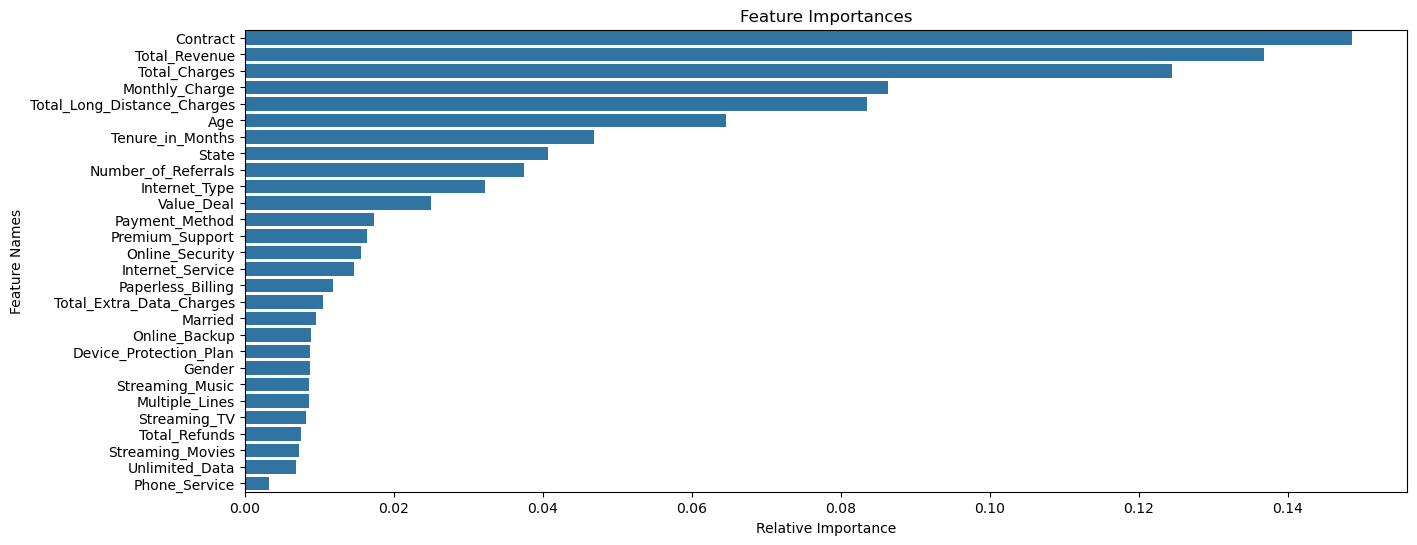

In [ ]:
y_pred = rf_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

importance_threshold = 0.02  
important_features = X.columns[importances > importance_threshold]
X_important = X[important_features]

X_train_imp, X_test_imp, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_improved = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
grid_search = GridSearchCV(estimator=rf_improved, param_grid=param_grid, 
                         cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_imp, y_train)

best_model = grid_search.best_estimator_

y_pred_improved = best_model.predict(X_test_imp)

print("Best parameters:", grid_search.best_params_)
print("\nImproved Model Performance:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_improved))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_improved))

Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Improved Model Performance:

Confusion Matrix:
[[706 141]
 [ 78 277]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       847
           1       0.66      0.78      0.72       355

    accuracy                           0.82      1202
   macro avg       0.78      0.81      0.79      1202
weighted avg       0.83      0.82      0.82      1202



In [ ]:
file_path = r"ChurnTrainData.xlsx"

sheet_name = 'vw_JoinData'

new_data = pd.read_excel(file_path, sheet_name=sheet_name)

print(new_data.head())

original_data = new_data.copy()

customer_ids = new_data['Customer_ID']

new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

for column in new_data.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        new_data[column] = label_encoders[column].transform(new_data[column])

new_data_important = new_data[important_features]

new_predictions = best_model.predict(new_data_important)

original_data['Customer_Status_Predicted'] = new_predictions

original_data = original_data[original_data['Customer_Status_Predicted'] == 1]

original_data.to_csv(r"PredictionsData.csv", index=False)



  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   11751-TAM  Female   18      No   Tamil Nadu                    5   
1   12056-WES    Male   27      No  West Bengal                    2   
2   12136-RAJ  Female   25     Yes    Rajasthan                    2   
3   12257-ASS  Female   39      No        Assam                    9   
4   12340-DEL  Female   51     Yes        Delhi                    0   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                 7     Deal 5            No             No  ...   
1                20        NaN           Yes             No  ...   
2                35        NaN           Yes             No  ...   
3                 1        NaN           Yes             No  ...   
4                10        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check      24.299999     38.450001           0.0   
1  Bank Withdrawal      90.4